In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report as report

### Load data


In [57]:
#lab data, extracted from mimic, preprocessed
lab = pd.read_csv("patients_no_text_sepsis_labels.csv")
#forecasts from strats model, trained on train data, and then tasked to forecast test patients that it did never encounter during training. It got 4 hours of input and forecast 12 next hours.
notext_forecasts = pd.read_pickle("4OBS12forecasting_preds_test.pkl")
forecasts = notext_forecasts[0]
var_map = list(notext_forecasts[1].keys())

In [58]:
#list of all variables
var_map

['o:Arterial_BE',
 'o:Arterial_lactate',
 'o:Arterial_pH',
 'o:BUN',
 'o:Calcium',
 'o:Chloride',
 'o:FiO2_1',
 'o:Glucose',
 'o:HCO3',
 'o:HR',
 'o:Hb',
 'o:INR',
 'o:Magnesium',
 'o:PT',
 'o:Potassium',
 'o:RR',
 'o:SGOT',
 'o:SGPT',
 'o:Shock_Index',
 'o:Sodium',
 'o:SysBP',
 'o:Temp_C',
 'o:Total_bili',
 'o:WBC_count',
 'o:Weight_kg',
 'o:paCO2',
 'o:paO2']

### Experiments on 16hours observed data. Without any forecasting, this is the performance benchmark given "perfect" data.

In [59]:
#test, train and val IDs were determined through GroupKFold splitting, ensuring that no patient is in more than one set.
IDs = pd.read_csv("IDs.csv")
train_IDs = np.unique(IDs["train_ids"][~np.isnan(IDs["train_ids"])])
test_IDs = np.unique(IDs["test_ids"][~np.isnan(IDs["test_ids"])])
val_IDs = np.unique(IDs["val_ids"][~np.isnan(IDs["val_ids"])])
print(np.intersect1d(train_IDs,test_IDs))
print(np.intersect1d(train_IDs,val_IDs))
print(np.intersect1d(test_IDs,val_IDs))


[]
[]
[]


### Prepare data
#### Train a classifier on train data, full 16hours
##### the two cells below only need to run once, to obtain concatenated and trimmed patient data.

In [ ]:
# classifying time series data works through concatenating all timesteps. This results in an input of #ofvariables*timesteps.
min_step = 16
thresh = min_step*(len(var_map)) 
# data for Classifier 1: trained on 16hours observed data, only lab features
temp_ = lab.copy()
#temp_["granular_label"] = np.where(((temp_["m:charttime"] >= temp_["m:presumed_onset"]) & (temp_["m:presumed_onset"] > 0.0)), 1, 0)
rows = temp_.drop(columns=["m:charttime", "traj", "r:reward", "a:action", "o:output_4hourly", "o:output_total", "o:PaO2_FiO2", "Unnamed: 0", "Unnamed: 0.1", "m:presumed_onset", "o:SOFA", "o:SIRS", "o:input_4hourly", "o:input_total", "o:GCS", "o:PTT", "o:DiaBP", "o:MeanBP", "o:SpO2", "o:cumulated_balance", "o:Creatinine", "o:Platelets_count", "o:re_admission", "o:mechvent", "o:max_dose_vaso"])
r = rows.copy()
r = r.loc[r["step"]<=16]

indexes = []
target = []
for id in tqdm(np.unique(r["m:icustayid"])):
    df_ = r["sepsis_label"].loc[r["m:icustayid"]==id]
    target.append(np.unique(df_).item())
    indexes.append(id)
ground_truths = pd.DataFrame({"m:icustayid": indexes,
                              "sepsis_label": target})

r.drop(columns=["step", "sepsis_label"], inplace=True)
temp2 = []
for ind in tqdm(ground_truths["m:icustayid"]):
    df_ = r[var_map].loc[r["m:icustayid"]==ind]
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(df_.values.flatten()))
df_ = r[var_map].loc[r["m:icustayid"]==ind]

# trim data to equal length for classification
preprocessed_data = [element[:thresh] for element in temp2] # should be shape [#ofpatients, minstep*#offeatures]
print(f"shape of preprocessed data: [{len(preprocessed_data)}, {len(preprocessed_data[0])}]")
print(f"number of patients: {len(temp2)}")
print(f"length of ground truth: {len(ground_truths)}")
print(f"length of desired patient data: {thresh}")


In [59]:
sequenced_data = ground_truths.copy()
sequenced_data["16hr_sequence"] = preprocessed_data
#sequenced_data.to_csv("16hour_sequenced_data_full.csv")
sequenced_data

,m:icustayid,sepsis_label,16hr_sequence
0,200003.0,1,"[1.0716606948959595, -0.5603590659566504, 1.06..."
1,200006.0,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,200007.0,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,200009.0,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,200010.0,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
...,...,...,...
43383,299988.0,1,"[-1.013270823925806, 0.264413846693113, -0.679..."
43384,299992.0,1,"[-0.5499527086320803, -0.3954044834266977, -0...."
43385,299993.0,0,"[-0.9698739817850311, -0.518149437444607, 0.85..."
43386,299995.0,1,"[-0.0866345933383545, 0.0994592641631602, -0.5..."


##### start here to load the preprocessed classification data

In [60]:
sequenced_data = pd.read_csv("16hour_sequenced_data_full.csv", converters={"16hr_sequence": pd.eval})


##### data for one patient is 16 (# of timesteps) x 27 (# of variables) = 432 long. At the moment it's all observed data.

In [61]:
t = sequenced_data["16hr_sequence"][0]
len(t)

432

### Split data in train and test sets, according to predetermined patient IDs and then bring in correct form for the classifier

In [62]:
train_val_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(np.concatenate([train_IDs, val_IDs]))]
train_val_data = pd.DataFrame(train_val_cohort["16hr_sequence"].tolist())
print("Traindata labelcounts:")
Counter(train_val_cohort["sepsis_label"])


Traindata labelcounts:


Counter({0: 19375, 1: 6043})

In [63]:
#the cohort holds IDs and sequences, but really is just used temporary
train_val_cohort.head()

,Unnamed: 0,m:icustayid,sepsis_label,16hr_sequence
1,1,200006.0,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,2,200007.0,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,3,200009.0,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,4,200010.0,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
8,8,200016.0,0,"[-0.0195401924382678, -0.9706157182387468, -0...."


In [64]:
#this is the data that is fed into the classifier
train_val_data.head()

,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,431
0,-0.019540,0.839249,0.177068,-0.519833,-0.856133,-2.316608,-0.115657,1.768155,1.696438,-0.244201,...,-0.122232,-0.498765,-0.376929,-0.372569,0.208684,-0.596517,-0.525228,-0.002233,-0.600907,-0.983718
1,-0.797086,-0.593560,-0.402613,-0.519833,1.454231,-0.166879,-0.565261,2.741363,-0.409980,0.418234,...,0.117270,0.638023,-0.140932,-0.686561,0.263830,-0.891924,-0.483909,1.860295,0.028029,-0.336411
2,1.276370,-0.970616,1.046590,-0.886600,-0.856133,-0.166879,-0.958665,-0.840042,0.760253,-1.418519,...,-0.927729,2.117314,1.039051,-1.440143,0.291403,-0.891924,0.399280,0.202816,0.028029,-0.434736
3,-0.149131,-0.744383,-0.040313,-0.519833,1.726039,0.012265,-0.565261,1.009053,0.058113,1.562441,...,-1.100451,0.009262,1.039051,0.019922,0.291403,-0.596517,-0.158523,-1.416216,0.656966,-0.549448
4,-0.019540,-0.970616,-0.402613,-1.075529,-1.127941,2.341137,-0.958665,-0.859506,-0.878073,-0.891581,...,-0.122232,-0.775056,1.275048,-0.074276,0.036354,0.025693,-0.716327,-0.788254,-0.181616,2.088944


##### do the same for test data

In [65]:
test_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(test_IDs)]
test_data = pd.DataFrame(test_cohort["16hr_sequence"].tolist())

In [66]:
test_cohort.head()

,Unnamed: 0,m:icustayid,sepsis_label,16hr_sequence
5,5,200011.0,1,"[1.0716606948959595, -0.8077909397515792, -1.3..."
29,29,200062.0,0,"[0.2396417501108494, -0.3673273438465604, 0.32..."
38,38,200079.0,0,"[-2.352177675380324, -0.4427383906455838, -1.2..."
49,49,200112.0,1,"[0.3766835219553712, 1.2541413418728289, 0.098..."
98,98,200224.0,0,"[0.2396417501108494, 0.2359610305456256, -0.25..."


In [67]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,431
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.829653,-0.336055,1.456557,-0.710920,...,1.524676,-1.181768,0.086192,0.992814,1.451676,-0.481630,-0.524785,0.772330,3.034376,-1.125315
1,0.239642,-0.367327,0.321988,0.207179,-1.399749,0.191409,-0.958665,-0.411831,-0.409980,-0.204053,...,-0.542739,0.967771,-0.848922,-0.851407,0.291403,0.766536,-0.390941,-0.019320,-0.915375,-0.877199
2,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,1.233156,-0.333974,-1.346165,-0.080743,...,1.305415,-0.345283,0.331061,-0.121375,0.291403,-0.596517,0.027411,0.151554,-0.600907,1.589124
3,0.376684,1.254141,0.098258,0.975679,1.338937,0.526251,-0.279641,-0.773852,-1.130851,0.248074,...,-0.602596,-0.168725,-0.110016,0.571898,0.004119,-0.663857,0.006959,3.491142,-0.733563,1.783013
4,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.565261,-0.625936,2.632624,0.237570,...,-1.582514,-0.840224,-0.376929,0.396713,0.318975,-1.272769,-0.561381,-0.749807,0.656966,-0.803455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5079,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,-0.958665,0.249951,-0.878073,1.682884,...,0.034327,0.603619,-2.500899,0.161219,0.401694,-0.891924,0.197851,-0.809613,-0.181616,-0.754293
5080,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,0.109145,-0.100404,0.526206,-0.665751,...,0.034327,-0.981012,-0.848922,0.208318,0.291403,-0.891924,0.507742,0.651361,-0.076793,-0.705130
5081,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,3.020434,2.252655,0.660432,-0.132015,...,-0.467386,3.029355,0.478608,-1.696373,0.050815,-0.886884,-0.309555,-0.731694,-0.374712,-0.947584
5082,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,0.109145,-0.684329,-0.644026,0.237570,...,-0.542739,-0.617189,0.331061,1.244493,0.291403,0.025693,-0.282480,-0.019320,0.971434,-0.442930


#### "train_test_split" the train data, note that no test data is used here

In [68]:
X_train, X_val, y_train, y_val = train_test_split(train_val_data, train_val_cohort["sepsis_label"], test_size=0.30, random_state=100,stratify=train_val_cohort["sepsis_label"])
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_val)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_val).items())


Shape of X_train: 17792
Shape of X_test: 7626
Class Balance in Training Data: dict_items([(1, 4230), (0, 13562)])
Class Balance in Test Data: dict_items([(0, 5813), (1, 1813)])


### Train classifier to predict Sepsis Label after 16 hours' worth of data. This is on fully observed data.

In [69]:
clf = make_pipeline(StandardScaler(),RandomForestClassifier(n_jobs=-1, verbose=1, random_state=111))

In [70]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=111,
                                        verbose=1))])

#### First, evaluate on the validation set, obtained by train_test_split, then on the held out test data that only contains patients that were not in the train/val data.

In [71]:
print("Score on validation set obtained through train_test_split:", clf.score(X_val, y_val))
pr_forest = clf.predict(test_data)
print("Scores on Testpatients, not observed during training: \n",report(y_true=test_cohort["sepsis_label"], y_pred=pr_forest))

Score on validation set obtained through train_test_split: 0.9752163650668765
Scores on Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      3896
           1       0.96      0.93      0.94      1188

    accuracy                           0.97      5084
   macro avg       0.97      0.96      0.96      5084
weighted avg       0.97      0.97      0.97      5084



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


### Combine 4 hours observed test with 12 hours forecast data.
#### Take 4xlen(var_map) columns from test_data (this corresponds to 4hours of observed data) and concat 12xlen(var_map) of the forecast data.

In [72]:
forecast_IDs = list(np.unique(forecasts["SUBJECT_ID"]))
forecast_observed_cohort = test_cohort.loc[test_cohort["m:icustayid"].isin(forecast_IDs)]

In [73]:
forecast_observed_cohort

,Unnamed: 0,m:icustayid,sepsis_label,16hr_sequence
5,5,200011.0,1,"[1.0716606948959595, -0.8077909397515792, -1.3..."
38,38,200079.0,0,"[-2.352177675380324, -0.4427383906455838, -1.2..."
98,98,200224.0,0,"[0.2396417501108494, 0.2359610305456256, -0.25..."
103,103,200232.0,0,"[0.2396417501108494, -0.2919162970475371, 0.90..."
121,121,200281.0,0,"[-0.5379040775365025, 3.176991855707534, -2.43..."
...,...,...,...,...
43327,43327,299861.0,0,"[-0.5379040775365025, 1.0654825453348815, 0.03..."
43348,43348,299911.0,0,"[0.7580056352090841, -0.3673273438465604, -0.2..."
43367,43367,299955.0,1,"[0.0060290297203905, 0.9242321768129234, -0.48..."
43378,43378,299976.0,0,"[0.4988236926599667, -0.2919162970475371, -0.2..."


#### observed data (only of test patients not seen during training)

In [74]:
forecast_observed_data = pd.DataFrame(forecast_observed_cohort["16hr_sequence"].tolist())
forecast_observed_data

,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,431
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.829653,-0.336055,1.456557,-0.710920,...,1.524676,-1.181768,0.086192,0.992814,1.451676,-0.481630,-0.524785,0.772330,3.034376,-1.125315
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,1.233156,-0.333974,-1.346165,-0.080743,...,1.305415,-0.345283,0.331061,-0.121375,0.291403,-0.596517,0.027411,0.151554,-0.600907,1.589124
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.565261,-0.625936,2.632624,0.237570,...,-1.582514,-0.840224,-0.376929,0.396713,0.318975,-1.272769,-0.561381,-0.749807,0.656966,-0.803455
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.958665,-0.723257,-0.409980,-0.214090,...,1.632311,0.151393,-0.848922,-0.639462,0.346548,1.586046,-0.344458,0.950390,1.128669,-0.209407
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,-0.958665,0.288879,1.228346,0.734397,...,-0.122232,0.120264,-1.320916,-0.403968,0.263830,-0.891924,-0.143029,0.706895,-0.076793,-0.664161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,-0.958665,0.249951,-0.878073,1.682884,...,0.034327,0.603619,-2.500899,0.161219,0.401694,-0.891924,0.197851,-0.809613,-0.181616,-0.754293
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,0.109145,-0.100404,0.526206,-0.665751,...,0.034327,-0.981012,-0.848922,0.208318,0.291403,-0.891924,0.507742,0.651361,-0.076793,-0.705130
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,3.020434,2.252655,0.660432,-0.132015,...,-0.467386,3.029355,0.478608,-1.696373,0.050815,-0.886884,-0.309555,-0.731694,-0.374712,-0.947584
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,0.109145,-0.684329,-0.644026,0.237570,...,-0.542739,-0.617189,0.331061,1.244493,0.291403,0.025693,-0.282480,-0.019320,0.971434,-0.442930


#### trim to 4 hours

In [75]:
len_obs = 4*len(var_map) 
obs = forecast_observed_data.iloc[:,:len_obs]
print(len_obs, obs.head())

108         0         1         2         3         4         5         6    \
0  1.071661 -0.807791 -1.359161  1.099965  0.094949 -0.275503 -0.829653   
1 -2.352178 -0.442738 -1.272136  0.798865  1.454231  0.191409  1.233156   
2  0.239642  0.235961 -0.257693  1.803683 -1.399749 -2.674896 -0.565261   
3  0.239642 -0.291916  0.901670 -0.763379 -1.807460  0.191409 -0.958665   
4 -0.537904  3.176992 -2.431498  1.365751 -1.263845 -2.316608 -0.958665   

        7         8         9    ...       98        99        100       101  \
0 -0.336055  1.456557 -0.710920  ... -0.018693 -0.959008  0.282400  0.684142   
1 -0.333974 -1.346165 -0.080743  ...  0.572208  0.411471 -0.376929 -0.792534   
2 -0.625936  2.632624  0.237570  ... -1.582514 -1.087175  1.039051  2.469064   
3 -0.723257 -0.409980 -0.214090  ...  2.550452  0.846463 -0.376929 -0.969155   
4  0.288879  1.228346  0.734397  ...  0.449475  0.389239 -1.792909 -0.050726   

        102       103       104       105       106       107  


#### obtain 12 hours of forecast data from strats

In [76]:
forecast_preds_data = pd.DataFrame(forecasts["forecasting_pred"].tolist())
forecast_preds_data

,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
0,0.303012,-0.699533,-0.580251,0.953035,0.522661,0.342918,-0.749332,-0.307659,0.877949,-0.958729,...,0.377069,-0.900381,0.688495,1.536553,1.383379,-0.623937,2.161561,-3.386340,0.654915,0.533363
1,-0.347423,-0.080624,-0.073375,1.499669,0.796838,0.162941,-0.663240,-0.600368,-0.423941,-0.441733,...,-0.674016,-0.736916,0.559890,-0.340276,0.886713,-0.863626,0.147103,-2.092694,0.975906,1.010033
2,-0.312636,0.049900,-0.068600,1.191012,0.580360,-1.628592,-0.633199,-1.569270,1.813349,-0.685266,...,0.368306,-1.848743,0.363738,1.486218,1.651763,-0.749097,2.462872,-3.774960,1.166949,0.812578
3,0.433486,0.259917,0.773526,-0.180754,0.331341,-0.735491,1.805495,-0.426322,0.113258,0.366788,...,-0.708194,-1.279988,0.445975,0.276518,1.316408,-1.300395,0.413619,-2.223499,0.187746,0.885410
4,-0.009444,0.231674,0.139158,1.060626,-1.162775,-0.385828,-0.634040,-0.390195,0.417638,-0.409012,...,-0.320415,-2.435787,1.088441,2.557721,1.230188,0.607433,3.717034,-2.317483,0.543995,1.200354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-1.846346,0.328534,-1.959726,1.503370,1.451210,-2.165801,-0.090145,0.201813,-0.978748,-0.212792,...,0.233708,-1.780137,1.165539,0.661671,1.557010,-0.592326,1.397320,-2.542159,0.363768,0.784761
3919,0.173474,0.495249,0.182421,0.509634,0.091709,0.464441,-0.117679,0.342294,0.265438,-0.231526,...,-0.555709,-1.051923,0.428054,0.178248,1.066824,-1.266552,0.729834,-2.123276,-0.047030,0.677475
3920,0.415213,1.421879,0.809066,0.699590,-0.512429,0.151248,-0.358924,-1.337130,0.177434,1.375077,...,0.117386,-1.713749,0.093629,0.646394,1.561231,-0.522046,2.439455,-2.312741,-0.123475,0.620884
3921,0.523997,0.286704,0.332333,0.891530,0.217700,-0.321281,0.524198,-0.269048,1.383466,0.111827,...,-0.562693,-0.509296,-0.482520,0.232028,2.096508,0.336967,2.071205,-2.963523,-0.322739,1.084231


#### concat 4 hours observed with 12 hours forecast (which strats did forecast after being trained on trainset and observing 4hours of test data as input)

In [77]:
forecast_test_data = pd.concat([obs, forecast_preds_data], axis=1)
forecast_test_data

,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.829653,-0.336055,1.456557,-0.710920,...,0.377069,-0.900381,0.688495,1.536553,1.383379,-0.623937,2.161561,-3.386340,0.654915,0.533363
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,1.233156,-0.333974,-1.346165,-0.080743,...,-0.674016,-0.736916,0.559890,-0.340276,0.886713,-0.863626,0.147103,-2.092694,0.975906,1.010033
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.565261,-0.625936,2.632624,0.237570,...,0.368306,-1.848743,0.363738,1.486218,1.651763,-0.749097,2.462872,-3.774960,1.166949,0.812578
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.958665,-0.723257,-0.409980,-0.214090,...,-0.708194,-1.279988,0.445975,0.276518,1.316408,-1.300395,0.413619,-2.223499,0.187746,0.885410
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,-0.958665,0.288879,1.228346,0.734397,...,-0.320415,-2.435787,1.088441,2.557721,1.230188,0.607433,3.717034,-2.317483,0.543995,1.200354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,-0.958665,0.249951,-0.878073,1.682884,...,0.233708,-1.780137,1.165539,0.661671,1.557010,-0.592326,1.397320,-2.542159,0.363768,0.784761
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,0.109145,-0.100404,0.526206,-0.665751,...,-0.555709,-1.051923,0.428054,0.178248,1.066824,-1.266552,0.729834,-2.123276,-0.047030,0.677475
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,3.020434,2.252655,0.660432,-0.132015,...,0.117386,-1.713749,0.093629,0.646394,1.561231,-0.522046,2.439455,-2.312741,-0.123475,0.620884
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,0.109145,-0.684329,-0.644026,0.237570,...,-0.562693,-0.509296,-0.482520,0.232028,2.096508,0.336967,2.071205,-2.963523,-0.322739,1.084231


#### Use the classifier trained on 16 hours of observed data.

In [78]:
prediction_on_forecast = clf.predict(forecast_test_data)
print("Scores on 4hour observed data + 12 hour forecast. \nOnly Testpatients, not observed during training: \n",report(y_true=forecast_observed_cohort["sepsis_label"], y_pred=prediction_on_forecast))

Scores on 4hour observed data + 12 hour forecast. 
Only Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3070
           1       0.22      1.00      0.36       853

    accuracy                           0.22      3923
   macro avg       0.11      0.50      0.18      3923
weighted avg       0.05      0.22      0.08      3923



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/pablo/.conda/envs/microsoft_sepsis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pablo/.conda/envs/microsoft_sepsis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pablo/.conda/envs/microsoft_sepsis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:

#### Unfortunately, the classifier is not able to utilize the forecast data in any meaningful way. Almost all predictions are label 1.

In [79]:
Counter(prediction_on_forecast)

Counter({1: 3923})

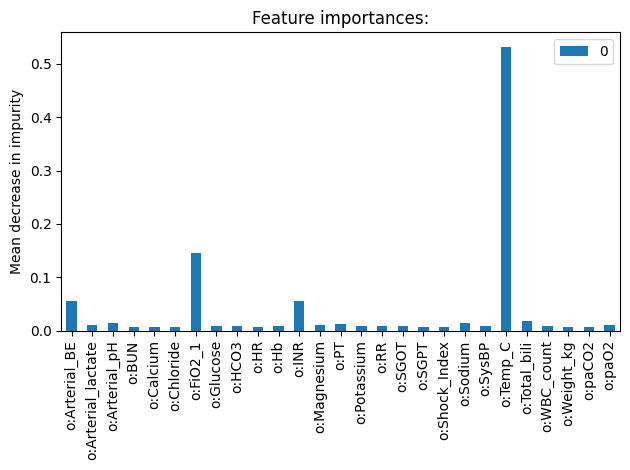

In [80]:
importances = clf[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf[1].estimators_], axis=0)
feature_names = var_map*min_step
forest_importances = pd.DataFrame(importances, index=feature_names)
imp = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')
fig, ax = plt.subplots()
imp.plot.bar(ax=ax)
ax.set_title(f"Feature importances:")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


### Now include tfidf data, obtained by training an classifier to find septic patients utilizing only tfidf data from patient notes.

#### Lab + Tfidf was used to train another strats model which was used to obtain the following forecasts.

In [81]:
lab_tfidf = pd.read_csv("lab_noteevents_tfidf_for_strats.csv")
text_forecasts_ = pd.read_pickle("4OBS12forecasting_text_preds_test.pkl")
text_forecasts = text_forecasts_[0]
var_map_text = list(text_forecasts_[1].keys())


In [82]:
text_IDs = np.unique(lab_tfidf["m:icustayid"])

In [83]:
text_truths = lab[["m:icustayid","sepsis_label"]].loc[lab["m:icustayid"].isin(text_IDs)]
text_truths

,m:icustayid,sepsis_label
0,200003.0,1
1,200003.0,1
2,200003.0,1
3,200003.0,1
4,200003.0,1
...,...,...
1991934,299999.0,0
1991935,299999.0,0
1991936,299999.0,0
1991937,299999.0,0


#### create the concatenated patient data that is necessary for a classifier
#### the next two cells only need to run once to obtain the preprocessed data.

In [84]:
min_step = 16
thresh = min_step*len(var_map_text)
# data for Classifier 1: trained on 16hours observed data, lab + tfidf features
temp_ = lab_tfidf.copy()

indexes = []
target = []
for id in tqdm(np.unique(temp_["m:icustayid"])):
    df_ = lab["sepsis_label"].loc[lab["m:icustayid"]==id]
    target.append(np.unique(df_).item())
    indexes.append(id)
ground_truths = pd.DataFrame({"m:icustayid": indexes,
                              "sepsis_label": target})

temp2 = []
for ind in tqdm(ground_truths["m:icustayid"]):
    df_ = lab_tfidf[var_map_text].loc[lab_tfidf["m:icustayid"]==ind]
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(df_.values.flatten()))

# trim data to equal length for classification
preprocessed_text_data = [element[:thresh] for element in temp2] # should be shape [#ofpatients, minstep*#offeatures]
print(f"shape of preprocessed data: [{len(preprocessed_text_data)}, {len(preprocessed_text_data[0])}]")
print(f"number of patients: {len(temp2)}")
print(f"length of ground truth: {len(ground_truths)}")
print(f"length of desired patient data: {thresh}")


 49%|████▉     | 20473/41774 [00:16<00:17, 1224.77it/s]


KeyboardInterrupt: 

In [ ]:
sequenced_data = ground_truths.copy()
sequenced_data["16hr_sequence"] = preprocessed_text_data
#sequenced_data.to_csv("16hour_sequenced_text_data_full.csv")
sequenced_data

,m:icustayid,sepsis_label,16hr_sequence
0,200003,1,"[1.0716606948959595, -0.5603590659566504, 1.06..."
1,200006,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,200007,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,200009,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,200010,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
...,...,...,...
41769,299988,1,"[-1.013270823925806, 0.264413846693113, -0.679..."
41770,299992,1,"[-0.5499527086320803, -0.3954044834266977, -0...."
41771,299993,0,"[-0.9698739817850311, -0.518149437444607, 0.85..."
41772,299995,1,"[-0.0866345933383545, 0.0994592641631602, -0.5..."


#### load concatenated patient data

In [85]:
sequenced_data = pd.read_csv("16hour_sequenced_text_data_full.csv", converters={"16hr_sequence": pd.eval})


#### build train and test sets according to the predetermined patient IDs
##### as before, train_val* is used for training a classifier, test is used to test said classifier and then 4 hours of test data is combined with 12 hours of forecast data obtained by a strats model which was also trained on train_val patients. That way we can compare how good our prediction of septic patients is based on forecast data, with and without textual information.

In [86]:
train_val_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(np.concatenate([train_IDs, val_IDs]))]
train_val_data = pd.DataFrame(train_val_cohort["16hr_sequence"].tolist())
Counter(train_val_cohort["sepsis_label"])

Counter({0: 19375, 1: 6043})

In [87]:
train_val_cohort.head()

,Unnamed: 0,m:icustayid,sepsis_label,16hr_sequence
1,1,200006,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,2,200007,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,3,200009,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,4,200010,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
7,7,200016,0,"[-0.0195401924382678, -0.9706157182387468, -0...."


##### data for this classifier is longer, because we use 50 more features

In [88]:
train_val_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231
0,-0.019540,0.839249,0.177068,-0.519833,-0.856133,-2.316608,-0.115657,1.768155,1.696438,-0.244201,...,0.000000,0.000000,0.000000,0.0,0.000000,0.511845,0.000000,0.0,0.000000,0.000000
1,-0.797086,-0.593560,-0.402613,-0.519833,1.454231,-0.166879,-0.565261,2.741363,-0.409980,0.418234,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,1.276370,-0.970616,1.046590,-0.886600,-0.856133,-0.166879,-0.958665,-0.840042,0.760253,-1.418519,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,-0.149131,-0.744383,-0.040313,-0.519833,1.726039,0.012265,-0.565261,1.009053,0.058113,1.562441,...,0.034852,0.581086,0.043404,0.0,0.235461,0.104876,0.116466,0.0,0.017256,0.000000
4,-0.019540,-0.970616,-0.402613,-1.075529,-1.127941,2.341137,-0.958665,-0.859506,-0.878073,-0.891581,...,0.072353,0.527768,0.000000,0.0,0.139661,0.000000,0.040297,0.0,0.035823,0.045015


In [89]:
test_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(test_IDs)]
test_data = pd.DataFrame(test_cohort["16hr_sequence"].tolist())

In [90]:
X_train, X_val, y_train, y_val = train_test_split(train_val_data, train_val_cohort["sepsis_label"], test_size=0.30, random_state=100,stratify=train_val_cohort["sepsis_label"])
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_val)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_val).items())


Shape of X_train: 17792
Shape of X_test: 7626
Class Balance in Training Data: dict_items([(1, 4230), (0, 13562)])
Class Balance in Test Data: dict_items([(0, 5813), (1, 1813)])


#### train classifier with lab+tfidf data 16 hours observed

In [93]:
clf_text = make_pipeline(StandardScaler(),RandomForestClassifier(n_jobs=-1, verbose=1, random_state=111))


In [94]:
clf_text.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=111,
                                        verbose=1))])

In [95]:
print("Score:", clf_text.score(X_val, y_val))
pr_forest = clf_text.predict(test_data)
print("Scores on Testpatients, not observed during training: \n",report(y_true=test_cohort["sepsis_label"], y_pred=pr_forest))

Score: 0.9731182795698925
Scores on Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      3896
           1       0.97      0.91      0.94      1188

    accuracy                           0.97      5084
   macro avg       0.97      0.95      0.96      5084
weighted avg       0.97      0.97      0.97      5084



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [96]:
forecast_IDs = list(np.unique(text_forecasts["SUBJECT_ID"]))
forecast_observed_cohort = test_cohort.loc[test_cohort["m:icustayid"].isin(forecast_IDs)]

In [97]:
forecast_observed_cohort

,Unnamed: 0,m:icustayid,sepsis_label,16hr_sequence
5,5,200011,1,"[1.0716606948959595, -0.8077909397515792, -1.3..."
36,36,200079,0,"[-2.352177675380324, -0.4427383906455838, -1.2..."
96,96,200224,0,"[0.2396417501108494, 0.2359610305456256, -0.25..."
101,101,200232,0,"[0.2396417501108494, -0.2919162970475371, 0.90..."
118,118,200281,0,"[-0.5379040775365025, 3.176991855707534, -2.43..."
...,...,...,...,...
41715,41715,299861,0,"[-0.5379040775365025, 1.0654825453348815, 0.03..."
41735,41735,299911,0,"[0.7580056352090841, -0.3673273438465604, -0.2..."
41753,41753,299955,1,"[0.0060290297203905, 0.9242321768129234, -0.48..."
41764,41764,299976,0,"[0.4988236926599667, -0.2919162970475371, -0.2..."


#### build 4 hours of observed data and combine with the forecast data

In [98]:
forecast_observed_data = pd.DataFrame(forecast_observed_cohort["16hr_sequence"].tolist())
forecast_observed_data

,0,1,2,3,4,5,6,7,8,9,...,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.829653,-0.336055,1.456557,-0.710920,...,0.079351,0.854435,0.000000,0.0,0.000000,0.000000,0.044195,0.000000,0.013096,0.000000
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,1.233156,-0.333974,-1.346165,-0.080743,...,0.074743,0.000000,0.000000,0.0,0.000000,0.149942,0.083257,0.000000,0.000000,0.372018
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.565261,-0.625936,2.632624,0.237570,...,0.000000,0.000000,0.000000,0.0,0.183942,0.000000,0.000000,0.405157,0.188723,0.000000
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.958665,-0.723257,-0.409980,-0.214090,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.548597,0.000000,0.000000,0.000000
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,-0.958665,0.288879,1.228346,0.734397,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,-0.958665,0.249951,-0.878073,1.682884,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.175985,0.000000,0.000000,0.000000
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,0.109145,-0.100404,0.526206,-0.665751,...,0.000000,0.000000,0.000000,0.0,0.000000,0.369094,0.000000,0.000000,0.000000,0.000000
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,3.020434,2.252655,0.660432,-0.132015,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.254454,0.000000,0.000000,0.000000
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,0.109145,-0.684329,-0.644026,0.237570,...,0.000000,0.000000,0.205561,0.0,0.000000,0.496686,0.367720,0.000000,0.000000,0.000000


In [99]:
len_obs = 4*len(var_map_text) 
obs = forecast_observed_data.iloc[:,:len_obs]
print(len_obs, obs.head())

308         0         1         2         3         4         5         6    \
0  1.071661 -0.807791 -1.359161  1.099965  0.094949 -0.275503 -0.829653   
1 -2.352178 -0.442738 -1.272136  0.798865  1.454231  0.191409  1.233156   
2  0.239642  0.235961 -0.257693  1.803683 -1.399749 -2.674896 -0.565261   
3  0.239642 -0.291916  0.901670 -0.763379 -1.807460  0.191409 -0.958665   
4 -0.537904  3.176992 -2.431498  1.365751 -1.263845 -2.316608 -0.958665   

        7         8         9    ...       298       299       300  301  \
0 -0.336055  1.456557 -0.710920  ...  0.079351  0.854435  0.000000  0.0   
1 -0.333974 -1.346165 -0.080743  ...  0.066636  0.000000  0.000000  0.0   
2 -0.625936  2.632624  0.237570  ...  0.000000  0.000000  0.000000  0.0   
3 -0.723257 -0.409980 -0.214090  ...  0.000000  0.000000  0.223849  0.0   
4  0.288879  1.228346  0.734397  ...  0.091134  0.000000  0.000000  0.0   

        302       303       304  305       306       307  
0  0.000000  0.000000  0.044195  0.

In [100]:
forecast_preds_data = pd.DataFrame(text_forecasts["forecasting_pred"].tolist())
forecast_preds_data

,0,1,2,3,4,5,6,7,8,9,...,914,915,916,917,918,919,920,921,922,923
0,1.145155,-0.293725,-0.606293,1.056314,0.379904,-1.222412,-0.486741,-0.456282,1.212725,-0.755742,...,0.064287,-0.032787,0.095336,-0.055411,-0.042546,0.019868,-0.023749,-0.045908,-0.011684,0.001959
1,-1.055523,-0.644963,0.609364,0.995557,1.605914,0.278057,0.085730,-0.379633,-1.349931,-0.308309,...,0.066334,-0.018660,0.039944,0.054490,0.002429,0.066123,0.157186,-0.003744,0.006158,0.045650
2,0.653939,-0.368828,-0.364512,0.632352,0.108418,-1.707179,0.911597,0.593754,1.591511,-0.099006,...,0.103352,-0.044420,0.046092,-0.044611,-0.014843,0.050761,0.169771,-0.039133,0.012871,0.061350
3,0.283548,0.380046,0.744020,-0.645813,0.078838,-1.204806,0.181239,0.306812,-0.007397,0.883660,...,0.108792,-0.061541,0.029343,-0.096502,-0.013112,0.079741,0.139125,-0.042992,0.030819,0.022689
4,-0.207652,0.254820,0.054733,0.572124,-0.812010,-1.615585,-0.216748,0.305163,0.701791,0.289192,...,0.094105,-0.050760,-0.086998,-0.094667,-0.053493,-0.019160,0.231943,-0.126841,-0.021668,0.052982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-1.113897,-0.008015,-0.746979,1.425112,1.520074,-2.709690,0.519824,0.837671,-0.537296,-0.661912,...,0.067109,0.002535,0.025580,0.013837,-0.044893,-0.020953,0.138069,-0.074111,-0.033539,0.066015
3919,-0.285508,0.110915,-0.609834,0.135897,-0.513915,-0.175228,-0.963533,-0.124886,0.407185,-0.072719,...,0.042219,-0.022591,0.021365,0.039905,-0.033262,0.029806,0.149543,-0.033601,-0.024498,0.048375
3920,0.012576,0.050756,0.328997,0.714934,1.145462,0.204061,0.309800,-0.726423,0.372975,0.227584,...,0.026143,-0.006884,0.042757,0.114003,-0.031701,0.032011,0.140434,-0.035680,-0.033345,0.045692
3921,0.129302,-0.973717,0.160681,0.308170,0.694088,-0.873573,0.006534,0.117818,0.226407,0.033542,...,0.075450,-0.028921,0.089234,-0.134389,-0.029684,0.024449,0.123041,-0.029788,-0.010945,0.068542


In [101]:
forecast_test_data = pd.concat([obs, forecast_preds_data], axis=1)
forecast_test_data

,0,1,2,3,4,5,6,7,8,9,...,914,915,916,917,918,919,920,921,922,923
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.829653,-0.336055,1.456557,-0.710920,...,0.064287,-0.032787,0.095336,-0.055411,-0.042546,0.019868,-0.023749,-0.045908,-0.011684,0.001959
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,1.233156,-0.333974,-1.346165,-0.080743,...,0.066334,-0.018660,0.039944,0.054490,0.002429,0.066123,0.157186,-0.003744,0.006158,0.045650
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.565261,-0.625936,2.632624,0.237570,...,0.103352,-0.044420,0.046092,-0.044611,-0.014843,0.050761,0.169771,-0.039133,0.012871,0.061350
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.958665,-0.723257,-0.409980,-0.214090,...,0.108792,-0.061541,0.029343,-0.096502,-0.013112,0.079741,0.139125,-0.042992,0.030819,0.022689
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,-0.958665,0.288879,1.228346,0.734397,...,0.094105,-0.050760,-0.086998,-0.094667,-0.053493,-0.019160,0.231943,-0.126841,-0.021668,0.052982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,-0.958665,0.249951,-0.878073,1.682884,...,0.067109,0.002535,0.025580,0.013837,-0.044893,-0.020953,0.138069,-0.074111,-0.033539,0.066015
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,0.109145,-0.100404,0.526206,-0.665751,...,0.042219,-0.022591,0.021365,0.039905,-0.033262,0.029806,0.149543,-0.033601,-0.024498,0.048375
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,3.020434,2.252655,0.660432,-0.132015,...,0.026143,-0.006884,0.042757,0.114003,-0.031701,0.032011,0.140434,-0.035680,-0.033345,0.045692
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,0.109145,-0.684329,-0.644026,0.237570,...,0.075450,-0.028921,0.089234,-0.134389,-0.029684,0.024449,0.123041,-0.029788,-0.010945,0.068542


#### use same classifier to predict labels based on 4 hours observed and 12 hours forecast data from strats

In [102]:
prediction_on_forecast = clf_text.predict(forecast_test_data)
print("Scores on 4hour observed data + 12 hour forecast. Only Testpatients, not observed during training: \n",report(y_true=forecast_observed_cohort["sepsis_label"], y_pred=prediction_on_forecast))

Scores on 4hour observed data + 12 hour forecast. Only Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.91      0.39      0.55      3070
           1       0.28      0.85      0.42       853

    accuracy                           0.49      3923
   macro avg       0.59      0.62      0.48      3923
weighted avg       0.77      0.49      0.52      3923



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


##### By utilizing tfidf data, our classifier performs signifcantly better.

In [103]:
Counter(prediction_on_forecast)

Counter({1: 2600, 0: 1323})

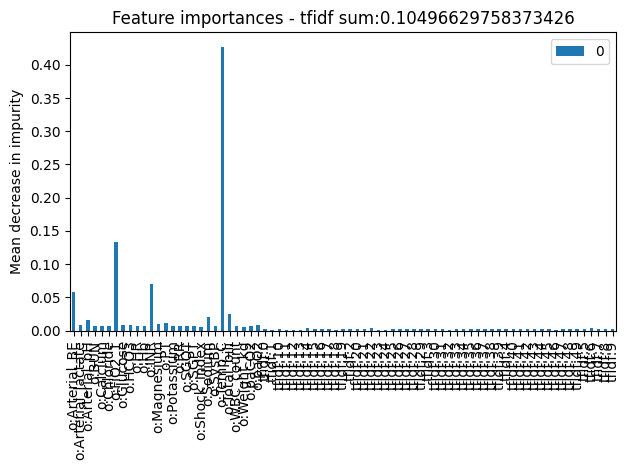

In [104]:
importances = clf_text[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_text[1].estimators_], axis=0)
feature_names = var_map_text*min_step
forest_importances = pd.DataFrame(importances, index=feature_names)
imp = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')
count = imp.loc[imp.index.str.contains('tfidf'), imp.columns].sum()
fig, ax = plt.subplots()
imp.plot.bar(ax=ax)
ax.set_title(f"Feature importances - tfidf sum:{count.item()}")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


### Now include sBert embeddings

#### Lab + sBert was used to train another strats model which was used to obtain the following forecasts.

In [105]:
lab_sBert = pd.read_csv("lab_sBert_concat_fulldata.csv")
text_forecasts_ = pd.read_pickle("4OBS12forecasting_text_preds_test_sBert.pkl")
text_forecasts = text_forecasts_[0]
var_map_text_sBert = list(text_forecasts_[1].keys())


In [106]:
text_IDs = np.unique(lab["m:icustayid"])

In [107]:
text_truths = lab[["m:icustayid","sepsis_label"]].loc[lab["m:icustayid"].isin(text_IDs)]
text_truths

,m:icustayid,sepsis_label
0,200003.0,1
1,200003.0,1
2,200003.0,1
3,200003.0,1
4,200003.0,1
...,...,...
1991934,299999.0,0
1991935,299999.0,0
1991936,299999.0,0
1991937,299999.0,0


#### create the concatenated patient data that is necessary for a classifier
#### the next two cells only need to run once to obtain the preprocessed data.

In [13]:
min_step = 16
thresh = min_step*len(var_map_text_sBert)
# data for Classifier 1: trained on 16hours observed data, lab + tfidf features
temp_ = lab_sBert.copy()

indexes = []
target = []
for id in tqdm(np.unique(temp_["m:icustayid"])):
    df_ = lab["sepsis_label"].loc[lab["m:icustayid"]==id]
    target.append(np.unique(df_).item())
    indexes.append(id)
ground_truths = pd.DataFrame({"m:icustayid": indexes,
                              "sepsis_label": target})

temp2 = []
for ind in tqdm(ground_truths["m:icustayid"]):
    df_ = lab_sBert[var_map_text].loc[lab_sBert["m:icustayid"]==ind]
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(df_.values.flatten()))

# trim data to equal length for classification
preprocessed_text_data = [element[:thresh] for element in temp2] # should be shape [#ofpatients, minstep*#offeatures]
print(f"shape of preprocessed data: [{len(preprocessed_text_data)}, {len(preprocessed_text_data[0])}]")
print(f"number of patients: {len(temp2)}")
print(f"length of ground truth: {len(ground_truths)}")
print(f"length of desired patient data: {thresh}")


100%|██████████| 41774/41774 [1:04:27<00:00, 10.80it/s]


shape of preprocessed data: [41774, 944]
number of patients: 41774
length of ground truth: 41774
length of desired patient data: 944


In [14]:
sequenced_data = ground_truths.copy()
sequenced_data["16hr_sequence"] = preprocessed_text_data
#sequenced_data.to_csv("16hour_sequenced_text_data_full_sBert.csv")
sequenced_data

,m:icustayid,sepsis_label,16hr_sequence
0,200003,1,"[1.0716606948959595, -0.5603590659566504, 1.06..."
1,200006,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,200007,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,200009,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,200010,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
...,...,...,...
41769,299988,1,"[-1.013270823925806, 0.264413846693113, -0.679..."
41770,299992,1,"[-0.5499527086320803, -0.3954044834266977, -0...."
41771,299993,0,"[-0.9698739817850311, -0.518149437444607, 0.85..."
41772,299995,1,"[-0.0866345933383545, 0.0994592641631602, -0.5..."


#### load concatenated patient data

In [108]:
sequenced_data = pd.read_csv("16hour_sequenced_text_data_full_sBert.csv", converters={"16hr_sequence": pd.eval})


#### build train and test sets according to the predetermined patient IDs
##### as before, train_val* is used for training a classifier, test is used to test said classifier and then 4 hours of test data is combined with 12 hours of forecast data obtained by a strats model which was also trained on train_val patients. That way we can compare how good our prediction of septic patients is based on forecast data, with and without textual information.

In [132]:
train_val_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(np.concatenate([train_IDs, val_IDs]))]
train_val_data = pd.DataFrame(train_val_cohort["16hr_sequence"].tolist())
Counter(train_val_cohort["sepsis_label"])

Counter({0: 19375, 1: 6043})

In [133]:
train_val_cohort.head()

,Unnamed: 0,m:icustayid,sepsis_label,16hr_sequence
1,1,200006,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,2,200007,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,3,200009,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,4,200010,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
7,7,200016,0,"[-0.0195401924382678, -0.9706157182387468, -0...."


##### data for this classifier is longer, because we use 50 more features

In [134]:
train_val_data.head()

,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
0,-0.019540,0.839249,0.177068,-0.519833,-0.856133,-2.316608,-0.115657,1.768155,1.696438,-0.244201,...,-0.048843,0.036530,0.013175,-0.093648,0.070102,-0.074058,0.098017,-0.251503,0.001572,-0.020767
1,-0.797086,-0.593560,-0.402613,-0.519833,1.454231,-0.166879,-0.565261,2.741363,-0.409980,0.418234,...,0.021328,-0.040359,0.028285,-0.110488,-0.078340,-0.196124,-0.101987,-0.272847,-0.069477,0.088116
2,1.276370,-0.970616,1.046590,-0.886600,-0.856133,-0.166879,-0.958665,-0.840042,0.760253,-1.418519,...,-0.046530,0.119966,0.059132,-0.118762,-0.064846,-0.179691,-0.147846,-0.340764,-0.097445,-0.058355
3,-0.149131,-0.744383,-0.040313,-0.519833,1.726039,0.012265,-0.565261,1.009053,0.058113,1.562441,...,-0.069298,0.123715,0.065286,-0.063597,-0.093426,-0.062556,0.067214,-0.307858,-0.043762,0.023189
4,-0.019540,-0.970616,-0.402613,-1.075529,-1.127941,2.341137,-0.958665,-0.859506,-0.878073,-0.891581,...,0.016116,0.093001,0.128761,-0.092669,0.072417,-0.140739,-0.043366,-0.216038,0.003582,0.076563


In [135]:
test_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(test_IDs)]
test_data = pd.DataFrame(test_cohort["16hr_sequence"].tolist())

In [136]:
X_train, X_val, y_train, y_val = train_test_split(train_val_data, train_val_cohort["sepsis_label"], test_size=0.30, random_state=100,stratify=train_val_cohort["sepsis_label"])
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_val)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_val).items())


Shape of X_train: 17792
Shape of X_test: 7626
Class Balance in Training Data: dict_items([(1, 4230), (0, 13562)])
Class Balance in Test Data: dict_items([(0, 5813), (1, 1813)])


#### train classifier with lab+tfidf data 16 hours observed

In [137]:
clf_text_sBert = make_pipeline(StandardScaler(),RandomForestClassifier(n_jobs=-1, verbose=1, random_state=111))


In [138]:
clf_text_sBert.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=111,
                                        verbose=1))])

In [139]:
print("Score:", clf_text_sBert.score(X_val, y_val))
pr_forest = clf_text_sBert.predict(test_data)
print("Scores on Testpatients, not observed during training: \n",report(y_true=test_cohort["sepsis_label"], y_pred=pr_forest))

Score: 0.9720692368214005
Scores on Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      3896
           1       0.96      0.91      0.94      1188

    accuracy                           0.97      5084
   macro avg       0.97      0.95      0.96      5084
weighted avg       0.97      0.97      0.97      5084



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [140]:
forecast_IDs = list(np.unique(text_forecasts["SUBJECT_ID"]))
forecast_observed_cohort = test_cohort.loc[test_cohort["m:icustayid"].isin(forecast_IDs)]

In [141]:
forecast_observed_cohort

,Unnamed: 0,m:icustayid,sepsis_label,16hr_sequence
5,5,200011,1,"[1.0716606948959595, -0.8077909397515792, -1.3..."
36,36,200079,0,"[-2.352177675380324, -0.4427383906455838, -1.2..."
96,96,200224,0,"[0.2396417501108494, 0.2359610305456256, -0.25..."
101,101,200232,0,"[0.2396417501108494, -0.2919162970475371, 0.90..."
118,118,200281,0,"[-0.5379040775365025, 3.176991855707534, -2.43..."
...,...,...,...,...
41715,41715,299861,0,"[-0.5379040775365025, 1.0654825453348815, 0.03..."
41735,41735,299911,0,"[0.7580056352090841, -0.3673273438465604, -0.2..."
41753,41753,299955,1,"[0.0060290297203905, 0.9242321768129234, -0.48..."
41764,41764,299976,0,"[0.4988236926599667, -0.2919162970475371, -0.2..."


#### build 4 hours of observed data and combine with the forecast data

In [142]:
forecast_observed_data = pd.DataFrame(forecast_observed_cohort["16hr_sequence"].tolist())
forecast_observed_data

,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.829653,-0.336055,1.456557,-0.710920,...,0.000532,0.234056,0.049997,-0.042811,-0.174802,-0.100519,0.111183,-0.443813,-0.105152,-0.110541
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,1.233156,-0.333974,-1.346165,-0.080743,...,-0.003735,0.008152,0.059569,0.040271,0.215500,-0.019677,-0.167447,-0.411514,0.087382,-0.007158
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.565261,-0.625936,2.632624,0.237570,...,-0.083519,0.262833,-0.017846,-0.082946,-0.121326,0.060702,-0.145589,-0.322625,-0.049575,0.056536
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.958665,-0.723257,-0.409980,-0.214090,...,0.008104,-0.117039,0.017781,-0.040276,-0.153256,0.012181,-0.042749,-0.329220,0.069891,0.080585
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,-0.958665,0.288879,1.228346,0.734397,...,-0.047830,0.106499,0.130329,-0.023301,0.138471,0.006639,0.042135,-0.130865,-0.004346,0.053635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,-0.958665,0.249951,-0.878073,1.682884,...,-0.038656,-0.189553,-0.088807,-0.100326,-0.043972,-0.043567,-0.179575,-0.236921,-0.039623,0.079906
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,0.109145,-0.100404,0.526206,-0.665751,...,0.009356,0.008187,-0.022061,0.036842,-0.091296,0.043367,-0.230568,-0.198416,-0.036765,-0.000408
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,3.020434,2.252655,0.660432,-0.132015,...,-0.002394,0.018623,0.048585,-0.085412,-0.070955,0.037460,0.000059,-0.510723,0.036410,-0.061946
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,0.109145,-0.684329,-0.644026,0.237570,...,-0.022873,-0.005279,0.142403,-0.101234,-0.018897,0.040222,-0.276890,-0.396722,-0.002637,0.022172


In [143]:
len_obs = 4*len(var_map_text_sBert) 
obs = forecast_observed_data.iloc[:,:len_obs]
print(len_obs, obs.head())

236         0         1         2         3         4         5         6    \
0  1.071661 -0.807791 -1.359161  1.099965  0.094949 -0.275503 -0.829653   
1 -2.352178 -0.442738 -1.272136  0.798865  1.454231  0.191409  1.233156   
2  0.239642  0.235961 -0.257693  1.803683 -1.399749 -2.674896 -0.565261   
3  0.239642 -0.291916  0.901670 -0.763379 -1.807460  0.191409 -0.958665   
4 -0.537904  3.176992 -2.431498  1.365751 -1.263845 -2.316608 -0.958665   

        7         8         9    ...       226       227       228       229  \
0 -0.336055  1.456557 -0.710920  ...  0.000532  0.234056  0.049997 -0.042811   
1 -0.333974 -1.346165 -0.080743  ... -0.007742 -0.036925  0.032849 -0.069091   
2 -0.625936  2.632624  0.237570  ... -0.167074  0.222608 -0.030623 -0.104055   
3 -0.723257 -0.409980 -0.214090  ... -0.062231  0.093501  0.029141 -0.087329   
4  0.288879  1.228346  0.734397  ...  0.143111  0.067911  0.118973 -0.075184   

        230       231       232       233       234       235  


In [144]:
forecast_preds_data = pd.DataFrame(text_forecasts["forecasting_pred"].tolist())
forecast_preds_data

,0,1,2,3,4,5,6,7,8,9,...,698,699,700,701,702,703,704,705,706,707
0,0.242981,-0.288689,-0.049197,0.858326,1.057424,-0.409364,0.410892,-0.046851,0.213577,0.208179,...,-0.052623,0.233002,0.058142,-0.079270,-0.048433,-0.011489,-0.136133,-0.278796,0.050666,-0.065142
1,-0.539424,-0.601406,-0.257177,0.651257,0.840029,0.330620,1.172948,-0.486911,-1.168032,-0.999124,...,-0.063148,0.238344,0.069496,-0.100253,-0.068950,0.026438,-0.127275,-0.268114,0.057901,-0.082146
2,0.863301,0.204554,-0.344313,0.588738,-0.222156,-1.290629,1.218431,-0.013287,1.910687,-0.750962,...,-0.048118,0.171457,0.048153,-0.104014,-0.023332,-0.031781,-0.134176,-0.257734,0.075270,-0.061985
3,0.487905,-0.102012,0.031309,-0.470148,-0.517852,-0.874351,-0.637468,-0.142741,-0.063374,0.305140,...,-0.065450,0.199483,0.061114,-0.102030,-0.066890,-0.052352,-0.107333,-0.255214,0.003222,-0.043410
4,0.238472,-0.186796,-0.649135,1.578527,-0.604279,-1.545380,2.914179,0.112746,1.729781,-0.644743,...,-0.047014,0.291224,0.058532,-0.082796,-0.055821,0.025680,-0.114613,-0.237816,0.079822,-0.098091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.904662,0.577301,-0.705762,1.541657,0.172719,-1.699441,2.082882,0.143910,-1.005896,-0.504987,...,-0.051769,0.333322,0.062216,-0.087442,-0.052451,0.013228,-0.115345,-0.231669,0.073835,-0.086504
3919,-0.172297,0.423076,0.088485,0.648309,-1.348701,0.632316,-0.694520,0.579944,-0.589923,0.081701,...,-0.068920,0.247290,0.075749,-0.100713,-0.073740,0.029596,-0.122889,-0.245208,0.072984,-0.087412
3920,0.845146,1.281563,0.294467,0.362679,0.277765,-0.574776,-0.284372,2.095961,-0.963457,0.037456,...,-0.070778,0.273279,0.066944,-0.098026,-0.082527,0.007661,-0.112505,-0.271485,0.014420,-0.055825
3921,-0.019164,0.276502,-1.024982,1.054131,-0.051953,-0.417388,0.094052,0.734107,0.763981,-0.224039,...,-0.065071,0.237295,0.062114,-0.101244,-0.084534,-0.036281,-0.111804,-0.239699,0.006240,-0.042299


In [145]:
forecast_test_data = pd.concat([obs, forecast_preds_data], axis=1)
forecast_test_data

,0,1,2,3,4,5,6,7,8,9,...,698,699,700,701,702,703,704,705,706,707
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.829653,-0.336055,1.456557,-0.710920,...,-0.052623,0.233002,0.058142,-0.079270,-0.048433,-0.011489,-0.136133,-0.278796,0.050666,-0.065142
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,1.233156,-0.333974,-1.346165,-0.080743,...,-0.063148,0.238344,0.069496,-0.100253,-0.068950,0.026438,-0.127275,-0.268114,0.057901,-0.082146
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.565261,-0.625936,2.632624,0.237570,...,-0.048118,0.171457,0.048153,-0.104014,-0.023332,-0.031781,-0.134176,-0.257734,0.075270,-0.061985
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.958665,-0.723257,-0.409980,-0.214090,...,-0.065450,0.199483,0.061114,-0.102030,-0.066890,-0.052352,-0.107333,-0.255214,0.003222,-0.043410
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,-0.958665,0.288879,1.228346,0.734397,...,-0.047014,0.291224,0.058532,-0.082796,-0.055821,0.025680,-0.114613,-0.237816,0.079822,-0.098091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,-0.958665,0.249951,-0.878073,1.682884,...,-0.051769,0.333322,0.062216,-0.087442,-0.052451,0.013228,-0.115345,-0.231669,0.073835,-0.086504
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,0.109145,-0.100404,0.526206,-0.665751,...,-0.068920,0.247290,0.075749,-0.100713,-0.073740,0.029596,-0.122889,-0.245208,0.072984,-0.087412
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,3.020434,2.252655,0.660432,-0.132015,...,-0.070778,0.273279,0.066944,-0.098026,-0.082527,0.007661,-0.112505,-0.271485,0.014420,-0.055825
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,0.109145,-0.684329,-0.644026,0.237570,...,-0.065071,0.237295,0.062114,-0.101244,-0.084534,-0.036281,-0.111804,-0.239699,0.006240,-0.042299


#### use same classifier to predict labels based on 4 hours observed and 12 hours forecast data from strats

In [146]:
prediction_on_forecast = clf_text_sBert.predict(forecast_test_data)
print("Scores on 4hour observed data + 12 hour forecast. Only Testpatients, not observed during training: \n",report(y_true=forecast_observed_cohort["sepsis_label"], y_pred=prediction_on_forecast))

Scores on 4hour observed data + 12 hour forecast. Only Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      3070
           1       0.63      0.61      0.62       853

    accuracy                           0.84      3923
   macro avg       0.76      0.76      0.76      3923
weighted avg       0.84      0.84      0.84      3923



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


##### By utilizing tfidf data, our classifier performs signifcantly better.

In [147]:
Counter(prediction_on_forecast)

Counter({0: 3094, 1: 829})

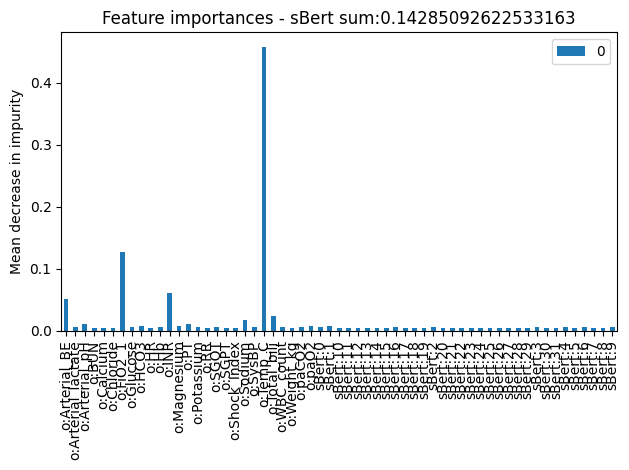

In [148]:
importances = clf_text_sBert[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_text_sBert[1].estimators_], axis=0)
feature_names = var_map_text_sBert*min_step
forest_importances = pd.DataFrame(importances, index=feature_names)
imp = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')
count = imp.loc[imp.index.str.contains('sBert'), imp.columns].sum()
fig, ax = plt.subplots()
imp.plot.bar(ax=ax)
ax.set_title(f"Feature importances - sBert sum:{count.item()}")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
